#### Changing Display Size for WideScreen

In [5]:
# Change cell size to the 90% of the screen (widescreen)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

#### Importing Libraries

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from scipy.io import wavfile
import python_speech_features
from tqdm.notebook import tqdm
import sounddevice as sd
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import butter, sosfilt
from timeit import default_timer as timer
from IPython.display import clear_output

#### Indexing words (labeling)


In [9]:
word2index = {"bed":0,
    "bird":1,
    "cat":2,
    "dog":3,
    "down":4,
    "eight":5,
    "five":6,
    "four":7,
    "go":8,
    "happy":9,
    "house":10,
    "left":11,
    "marvin":12,
    "nine":13,
    "no":14,
    "off":15,
    "on":16,
    "one":17,
    "right":18,
    "seven":19,
    "sheila":20,
    "six":21,
    "stop":22,
    "three":23,
    "tree":24,
    "two":25,
    "up":26,
    "wow":27,
    "yes":28,
    "zero":29,
    "backward":30,
    "follow":31,
    "forward":32,
    "learn":33,
    "visual":34}

index2word = [word for word in word2index]

#### Audio Feature Extraction

In [10]:
# compute MFCC features from audio signal
def audio2feature(audio):
    # compute MFCC coefficients
    features = python_speech_features.mfcc(audio, samplerate=16000, winlen=0.025, winstep=0.01, numcep=13, nfilt=40, nfft=512, lowfreq=100, highfreq=None, preemph=0.97, ceplifter=22, appendEnergy=True, winfunc=np.hamming)
    return features

# load .wav-file, add some noise and compute MFCC features
def wav2feature(filepath):
    samplerate, data = wavfile.read(filepath)
    # compute MFCC coefficients
    features = python_speech_features.mfcc(data, samplerate=16000, winlen=0.025, winstep=0.01, numcep=13, nfilt=40, nfft=512, lowfreq=100, highfreq=None, preemph=0.97, ceplifter=22, appendEnergy=True, winfunc=np.hamming)
    return features

#### Loading the model

In [11]:
model = keras.models.load_model("attRNN_35_final_demo.h5")

## Demo 1: from recorded .wav file

In [12]:
#This is a simple tool to take .wav audio files, identify the loudest segment of a given length, and then write out that segment as a new .wav file.
def extract_loudest_section(audio, length):
    audio = audio[:, 0].astype(np.float) # to avoid integer overflow when squaring
    audio_pw = audio**2 # power
    window = np.ones((length, ))
    conv = np.convolve(audio_pw, window, mode="valid")
    begin_index = conv.argmax()
    return audio[begin_index:begin_index+length]

Best predictions:
------------------------------
1.)	house	:	47.4%
2.)	bed	:	26.5%
3.)	wow	:	25.7%
------------------------------
Feature Computation Time: 4.0 ms


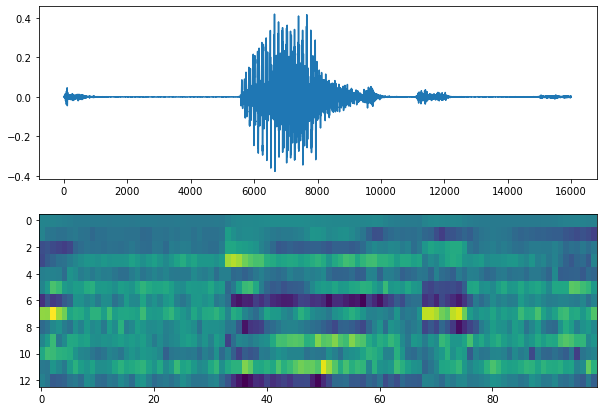

In [14]:
# Recording settings (16kHz mono channel)
sd.default.samplerate = 16000
sd.default.channels = 1, 2 # mono record, stereo playback

# 3 seconds recording
recording = sd.rec(int(3*sd.default.samplerate), channels=1, samplerate=sd.default.samplerate, dtype=np.float, blocking=True)
recording = extract_loudest_section(recording, int(1*sd.default.samplerate)) # extract 1s snippet with highest energy (only necessary if recording is >3s long)
sd.play(recording, blocking=True)

t1 = timer()
recorded_feature = audio2feature(recording)
t2 = timer()
recorded_feature = np.expand_dims(recorded_feature, 0) # adding extra dimension for network
prediction = model.predict(recorded_feature).reshape((35, ))
t3 = timer()
#  Prediction Normalization to get probabilities for labels
prediction /= prediction.sum()

# Print out the 3 labels with highest probability
prediction_sorted_indices = prediction.argsort()
print("Best predictions:\n------------------------------")
for k in range(3):
    i = int(prediction_sorted_indices[-1-k])
    print("%d.)\t%s\t:\t%2.1f%%" % (k+1, index2word[i], prediction[i]*100))
print("------------------------------")
print("Feature Computation Time: %2.1f ms" % ((t2-t1)*1e3))

plt.close()
plt.figure(1, figsize=(10, 7))
plt.subplot(211)
plt.plot(recording)
plt.subplot(212)
plt.imshow(recorded_feature.reshape(99, 13).T, aspect="auto")
plt.show()

## Demo 2: from microphone (real-time)

In [167]:
audio_buffer = np.zeros((2, 8000))
last_recognized_word = None
last_recognition_time = 0.0
recognition_timeout = 1.0

def audio_stream_callback(indata, frames, time, status):
    global audio_buffer
    global model
    global index2word
    global last_recognized_word
    global last_recognition_time
    audio_buffer = np.roll(audio_buffer, shift=-1, axis=0)
    audio_buffer[-1, :] = np.squeeze(indata)
    t1 = timer()
    recorded_feature = audio2feature(audio_buffer.flatten())
    recorded_feature = np.expand_dims(recorded_feature, 0) # add "fake" batch dimension 1
#     recorded_feature = recorded_feature[..., np.newaxis]
#     recorded_feature = np.expand_dims(recorded_feature, 0)
    t2 = timer()
    prediction = model.predict(recorded_feature).reshape((35, ))
    # normalize prediction output to get "probabilities"
    prediction /= prediction.sum()
    #print(prediction)
    best_candidate_index = prediction.argmax()
    best_candidate_probability = prediction[best_candidate_index]
    t3 = timer()
    if(best_candidate_probability > 0.7): # threshold for candidates
        word = index2word[best_candidate_index]
        if( (timer()-last_recognition_time)>recognition_timeout or word!=last_recognized_word ):
            last_recognition_time = timer()
            last_recognized_word = word
            clear_output(wait=True) # clear output as soon as new output is available to replace it
            print("%s\t:\t%2.1f%%" % (word, best_candidate_probability*100))
            print("-----------------------------")

In [165]:
# It tries to guess from the incoming audio signal by keeping the microphone on for X seconds.
with sd.InputStream(samplerate=16000, blocksize=8000, device=None, channels=1, dtype="float32", callback=audio_stream_callback):
    sd.sleep(20*1000)


go	:	85.2%
-----------------------------
